In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

## Graphe LR SSB(WS,SWH)

In [18]:
# Charger les données depuis le fichier CSV
data = pd.read_csv('/data/SSB_ETU/HLAFARGUE/S6JTEX/np_analysis/ssbcorr_S6A_LR_MLE4_42_79_out_ce_ep_moy_moy.rs', header=None, sep='\s+')

#data = pd.read_csv('/home/hlafargue/ssb_fortran/display_outputs/LR/ssb_S6A_LR_MLE4_42_79_phi1_out_ce_ep_moy.rs', header=None, sep='\s+')
# Renommer les colonnes
data.columns = ['SWH', 'WS', 'SSB']

data

,SWH,WS,SSB
0,0.00,0.00,0.000000
1,0.00,0.25,0.006988
2,0.00,0.50,0.004763
3,0.00,0.75,0.002418
4,0.00,1.00,0.000812
...,...,...,...
4027,11.75,19.75,-0.271949
4028,11.75,20.00,-0.272236
4029,11.75,20.25,-0.273030
4030,11.75,20.50,-0.274714


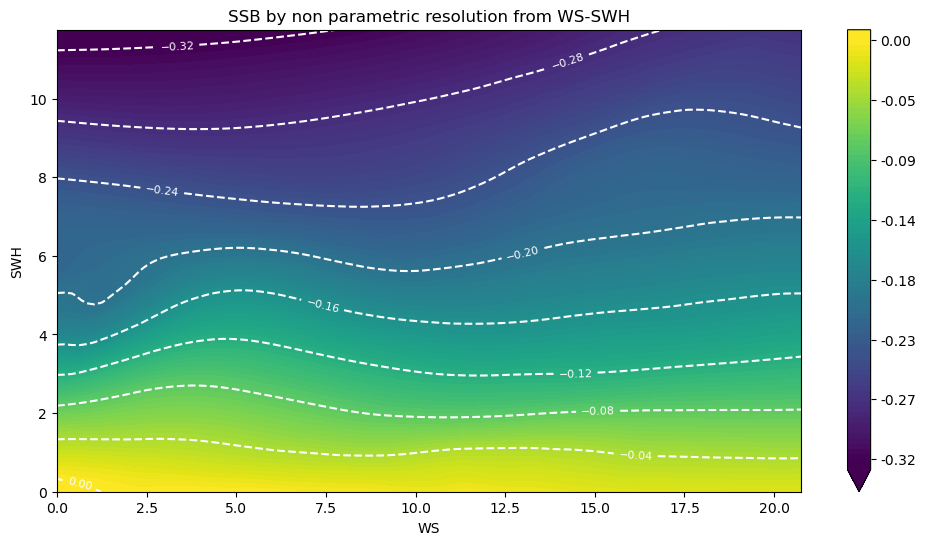

In [19]:
# Les colonnes sont accédées par nom
swh = data['SWH']
ws = data['WS']
ssb = data['SSB']

# Créer une grille régulière pour les variables SWH et WS
WS_vals, SWH_vals = np.mgrid[ws.min():ws.max():100j, swh.min():swh.max():100j]

# Interpoler les valeurs de SSB sur la grille
SSB_grid = griddata((ws, swh), ssb, (WS_vals, SWH_vals), method='cubic')

# Définir les limites pour le colorbar
vmin, vmax = -0.32, 0 

# Créer la figure
plt.figure(figsize=((12,6)))

# Tracer les courbes de niveau
contour = plt.contourf(WS_vals, SWH_vals, SSB_grid, levels=100, cmap='viridis', vmin=vmin, vmax=vmax, extend='min')
cbar = plt.colorbar(contour)
cbar.set_ticks(np.linspace(vmin, vmax, num=8))
cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(vmin, vmax, num=8)])
contours = plt.contour(WS_vals, SWH_vals, SSB_grid, colors='white', levels=10)
plt.clabel(contours, inline=True, fontsize=8)

# Ajouter des labels aux axes et le titre
plt.xlabel('WS')
plt.ylabel('SWH')
plt.title('SSB by non parametric resolution from WS-SWH')

# Afficher le graphique
plt.show()


## Graphe LR SSB(PC1,PC2)

In [24]:
# Charger les données depuis le fichier CSV
data_pc = pd.read_csv('/data/SSB_ETU/HLAFARGUE/S6JTEX/np_analysis/ssbcorr_S6A_LR_MLE4_PC_fen_m0_h1_3_h2_1pt5_42_79_out_ce_ep_moy_moy.rs', header=None, sep='\s+')
#data_pc = pd.read_csv('/home/hlafargue/ssb_fortran/display_outputs/LR_PC/fen_bis/ssbcorr_S6A_LR_PC_fen_bis_h1_3_h2_1pt5_MLE4_42_79_phi1_phi2_out_ce_ep_moy_moy.rs', header=None, sep='\s+')

# Renommer les colonnes
data_pc.columns = ['PC2', 'PC1', 'SSB']
# Les colonnes sont accédées par nom
pc1 = data_pc['PC1'] 
pc2 = data_pc['PC2'] 
ssb = data_pc['SSB']

data_pc

,PC2,PC1,SSB
0,-5.00,-8.00,0.014778
1,-5.00,-7.75,0.011242
2,-5.00,-7.50,0.007712
3,-5.00,-7.25,0.004184
4,-5.00,-7.00,0.000659
...,...,...,...
4027,6.75,11.75,-0.269097
4028,6.75,12.00,-0.269446
4029,6.75,12.25,-0.270716
4030,6.75,12.50,-0.272519


In [25]:
# Constantes
OVV_mean, OVV_std = 0.1011, 0.0365
ATSD_mean, ATSD_std = 0.0231, 0.0994
MWP_mean, MWP_std = 6.3952, 1.3952
WS_mean, WS_std = 8.3069, 3.7529
SWH_mean, SWH_std = 2.6900, 1.4052

# Coefficients
coefficients = {
    'PC1': [0.950, 0.568, 0.560, 0.831, 0.951],
    'PC2': [-0.214, -0.030, 0.814, -0.499, 0.188]
}

# Définir les valeurs min, mean, max
params = {
    'min': [OVV_mean - OVV_std, ATSD_mean - ATSD_std, MWP_mean - MWP_std],
    'mean': [OVV_mean, ATSD_mean, MWP_mean],
    'max': [OVV_mean + OVV_std, ATSD_mean + ATSD_std, MWP_mean + MWP_std]
}

# Standardisation des variables
def standardize(value, mean, std):
    return (value - mean) / std

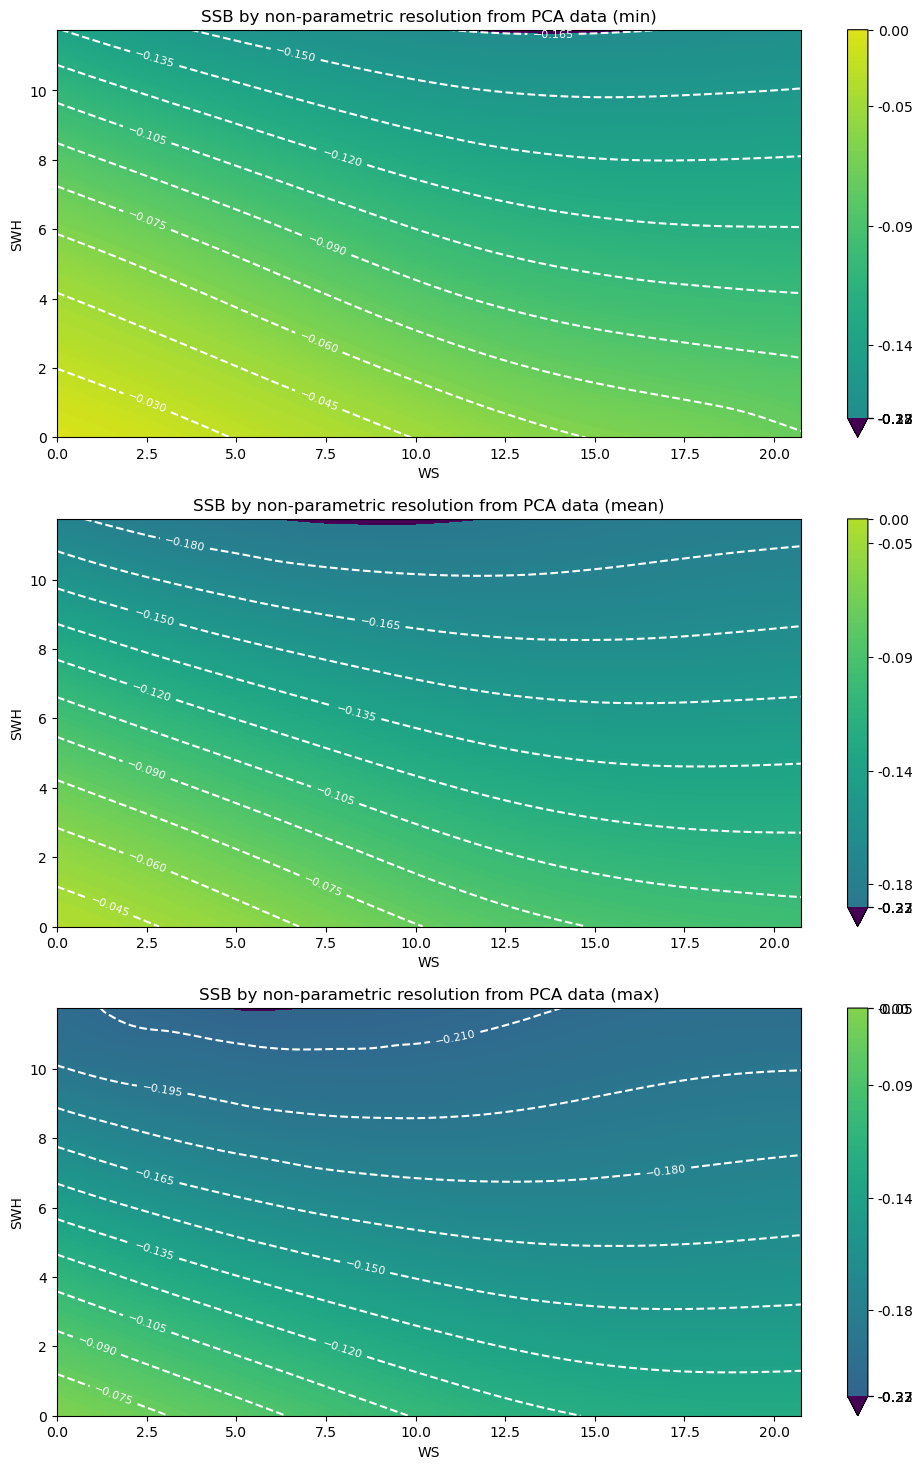

In [40]:
# Fonction pour calculer PC1 et PC2 à partir de WS et SWH
def calculate_pc1_pc2(ws_vals, swh_vals, ovv, atsd, mwp):
    b1 = (coefficients['PC1'][0] * standardize(ovv, OVV_mean, OVV_std) +
          coefficients['PC1'][1] * standardize(atsd, ATSD_mean, ATSD_std) +
          coefficients['PC1'][2] * standardize(mwp, MWP_mean, MWP_std))
    
    b2 = (coefficients['PC2'][0] * standardize(ovv, OVV_mean, OVV_std) +
          coefficients['PC2'][1] * standardize(atsd, ATSD_mean, ATSD_std) +
          coefficients['PC2'][2] * standardize(mwp, MWP_mean, MWP_std))
    
    pc1_vals = b1 + coefficients['PC1'][3] * standardize(ws_vals, WS_mean, WS_std) + coefficients['PC1'][4] * standardize(swh_vals, SWH_mean, SWH_std)
    pc2_vals = b2 + coefficients['PC2'][3] * standardize(ws_vals, WS_mean, WS_std) + coefficients['PC2'][4] * standardize(swh_vals, SWH_mean, SWH_std)
    
    return pc1_vals, pc2_vals

# Grille pour WS et SWH
WS_vals, SWH_vals = np.mgrid[data['WS'].min():data['WS'].max():100j, data['SWH'].min():data['SWH'].max():100j]

# Définir les limites pour le colorbar
vmin, vmax = -0.32, 0 

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 6*3))

for i, (key, (OVV, ATSD, MWP)) in enumerate(params.items()):
    # Calculer PC1 et PC2 à partir de la grille de WS et SWH
    pc1_vals, pc2_vals = calculate_pc1_pc2(WS_vals, SWH_vals, OVV, ATSD, MWP)

    # Interpoler SSB sur la grille
    SSB_grid = griddata((pc1, pc2), ssb, (pc1_vals, pc2_vals), method='cubic')

    # Tracer les courbes de niveau
    contour = axs[i].contourf(WS_vals, SWH_vals, SSB_grid, levels=100, cmap='viridis', vmin=vmin, vmax=vmax, extend='min')
    cbar = fig.colorbar(contour, ax=axs[i])
    cbar.set_ticks(np.linspace(vmin, vmax, num=8))
    cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(vmin, vmax, num=8)])
    contours = axs[i].contour(WS_vals, SWH_vals, SSB_grid, colors='white', levels=10)
    axs[i].set_title(f'SSB by non-parametric resolution from PCA data ({key})')
    axs[i].set_xlabel('WS')
    axs[i].set_ylabel('SWH')
    #fig.colorbar(contour, ax=axs[i])
    axs[i].clabel(contours, inline=True, fontsize=8)

plt.show()

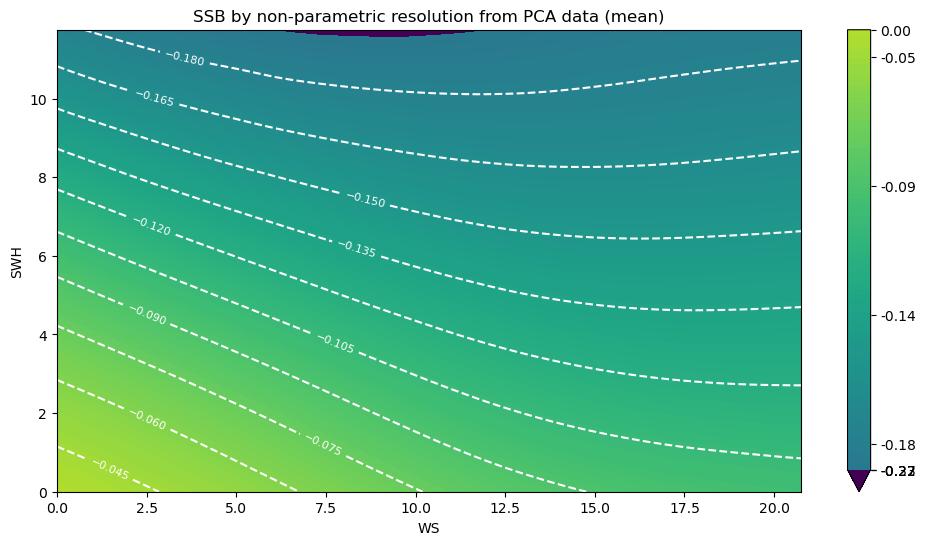

In [41]:
# Calculer PC1 et PC2 à partir de la grille de WS et SWH
pc1_vals, pc2_vals = calculate_pc1_pc2(WS_vals, SWH_vals, OVV_mean, ATSD_mean, MWP_mean)

# Interpoler SSB sur la grille
SSB_grid = griddata((pc1, pc2), ssb, (pc1_vals, pc2_vals), method='cubic')

# Définir les limites pour le colorbar
vmin, vmax = -0.32, 0 

# Créer la figure
plt.figure(figsize=((12,6)))

# Tracer les courbes de niveau
contour = plt.contourf(WS_vals, SWH_vals, SSB_grid, levels=100, cmap='viridis', vmin=vmin, vmax=vmax, extend='min')
cbar = plt.colorbar(contour)
cbar.set_ticks(np.linspace(vmin, vmax, num=8))
cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(vmin, vmax, num=8)])
contours = plt.contour(WS_vals, SWH_vals, SSB_grid, colors='white', levels=10)
plt.clabel(contours, inline=True, fontsize=8)

# Ajouter des labels aux axes et le titre
plt.xlabel('WS')
plt.ylabel('SWH')
plt.title('SSB by non-parametric resolution from PCA data (mean)')

# Afficher le graphique
plt.show()
